*Exploratory Data Analysis*

# Visualizing Depth Guided Sampling

In [69]:
import pickle
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyArrow, ArrowStyle
from mpl_toolkits.mplot3d import proj3d
from matplotlib.lines import Line2D
import torch
import itertools

from run_dnerf_helpers import get_rays
from load_deepdeform import load_deepdeform_data, pose_spiral
from utils import Arrow3D, draw_transformed, draw_cam

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading the validation logs.

In [70]:
with open("monitor.pickle", "rb") as f:
    frame_log = pickle.load(f)

print("Logged items (shape/value):")
for k in frame_log.keys():
    toprint = "\t\t" + k
    if isinstance(frame_log[k], torch.Tensor):
        toprint += "\t" + str(tuple(frame_log[k].shape))
    if isinstance(frame_log[k], float):
        toprint += "\t" + str(frame_log[k])
    print(toprint)

Logged items (shape/value):
		rays_o	(240, 320, 3)
		rays_d	(240, 320, 3)
		rgb_map	(240, 320, 3)
		depth_map	(240, 320, 1)
		z_coarse	(240, 320, 64)
		z_fine	(240, 320, 128)
		c2w	(3, 4)
		near	0.10000000149011612
		far	3608.85009765625


In [99]:
H, W, _ = frame_log["rgb_map"].shape
camera_pose = frame_log["c2w"]
rays_o = frame_log["rays_o"]
rays_d = frame_log["rays_d"]
rgb_map = frame_log["rgb_map"]
depth_map = frame_log["depth_map"]
z_coarse = frame_log["z_coarse"]
z_fine = frame_log["z_fine"]
near = frame_log["near"]
far = frame_log["far"]

pts_coarse = rays_o[...,None,:] + rays_d[...,None,:] * z_coarse[...,:,None]
pts_fine = rays_o[...,None,:] + rays_d[...,None,:] * z_fine[...,:,None]

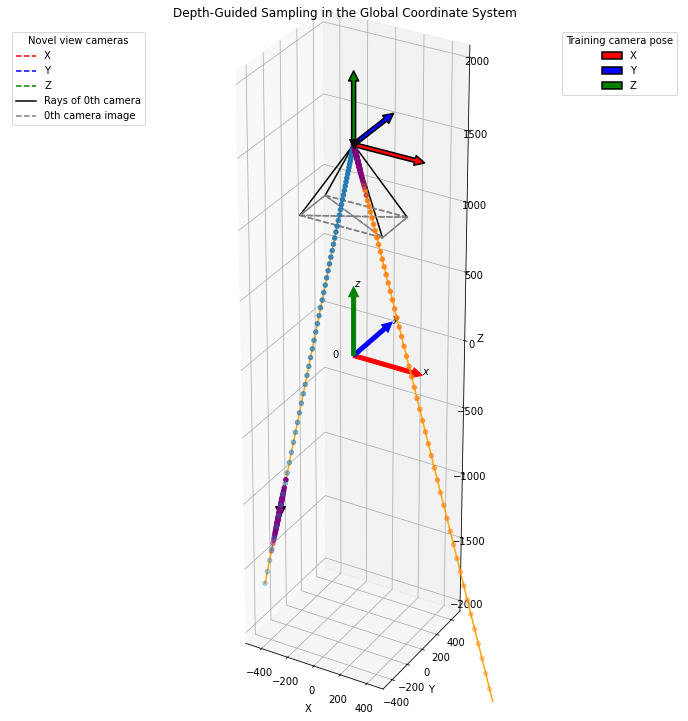

In [117]:

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')

xlim = [-500, 500]
ylim = [-500, 500]
zlim = [-2000, 2000]
ax1.set_xlabel('X')
ax1.set_xlim(*xlim)
ax1.set_ylabel('Y')
ax1.set_ylim(*ylim)
ax1.set_zlabel('Z')
ax1.set_zlim(*zlim)
ax1.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))       # -> length of 1 in each dimension is visually the equal

# The world coordinate system
axes_len = 500
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='simple', shrinkA=0, shrinkB=0)
ax1.add_artist(Arrow3D([0, axes_len], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
ax1.add_artist(Arrow3D([0, 0], [0, axes_len], [0, 0], **arrow_prop_dict, color='b'))
ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, axes_len], **arrow_prop_dict, color='g'))
ax1.text(-100, -100, 0, r'$0$')
ax1.text(axes_len, 0, 0, r'$x$')
ax1.text(0, axes_len, 0, r'$y$')
ax1.text(0, 0, axes_len, r'$z$')

# Draw the camera coordinate frame
tcx, tcy, tcz, _ = draw_transformed(camera_pose, ax1, arrowstyle='simple', axes_len=500, linewidth=1.5, mutation_scale=20, edgecolor="black")
# Draw the camera
draw_cam(rays_o, rays_d, ax1, focal_dist=500)       # rays_o and rays_d are already in world-coordinates

# Draw a ray with its samples
ith_ray = 100, 100
ray_ori = rays_o[ith_ray]
ray_dir = rays_d[ith_ray]
ray_near = ray_ori + near * ray_dir
ray_far = ray_ori + far * ray_dir
ax1.plot([ray_near[0], ray_far[0]], [ray_near[1], ray_far[1]], [ray_near[2], ray_far[2]], color="orange")

coarse = pts_coarse[ith_ray]
ax1.scatter(coarse[:,0], coarse[:,1], coarse[:,2])

fine = pts_fine[ith_ray]
ax1.scatter(fine[:,0], fine[:,1], fine[:,2], color="purple")

depth = depth_map[ith_ray]
depth = ray_ori + depth * ray_dir
ax1.scatter(depth[0], depth[1], depth[2], color="black", marker="v", s=100)

# Draw a ray with its samples
ith_ray = 150, 250
ray_ori = rays_o[ith_ray]
ray_dir = rays_d[ith_ray]
ray_near = ray_ori + near * ray_dir
ray_far = ray_ori + far * ray_dir
ax1.plot([ray_near[0], ray_far[0]], [ray_near[1], ray_far[1]], [ray_near[2], ray_far[2]], color="orange")

coarse = pts_coarse[ith_ray]
ax1.scatter(coarse[:,0], coarse[:,1], coarse[:,2])

fine = pts_fine[ith_ray]
ax1.scatter(fine[:,0], fine[:,1], fine[:,2], color="purple")

depth = depth_map[ith_ray]
depth = ray_ori + depth * ray_dir
ax1.scatter(depth[0], depth[1], depth[2], color="black", marker="v", s=100)

# Make the legends
lgnd1 = plt.legend(handles=[tcx, tcy, tcz], 
           labels=["X", "Y", "Z"], 
           title="Training camera pose", loc=1)
plt.legend(handles=[Line2D([0], [0], color='r', ls="--"), 
                    Line2D([0], [0], color='b', ls="--"), 
                    Line2D([0], [0], color='g', ls="--"), 
                    Line2D([0], [0], color='black', ls="-"),
                    Line2D([0], [0], color='grey', ls="--")], 
           labels=["X", "Y", "Z", "Rays of 0th camera", "0th camera image"], 
           title="Novel view cameras", loc=2)
plt.gca().add_artist(lgnd1)

fig.suptitle("Depth-Guided Sampling in the Global Coordinate System", )
fig.tight_layout()

plt.show()

In [101]:
depth

tensor([ -659.7190,   154.4994, -1466.6816])